In [1]:
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformation
import data_filter as dafi
import estimate_height as esth

from scipy import signal

WAVELENTH_S1 = 0.1905 # meter


In [2]:
# setting 0526 on the old bridge Cannstatt near wasen
main_path = os.path.abspath('E:/OneDrive/Studium/MA/data/20220526/3/')
time_split_length = 1800
azimut_mask = [140,180]
elevation_mask = [15,25]

In [3]:
# setting 0811 on the corner Esslingen
main_path = os.path.abspath('E:/OneDrive/Studium/MA/data/20220811/3/')
time_split_length = 1800
azimut_mask = [300,330]
elevation_mask = [0,25]

In [4]:
# setting 0907 on the corner Esslingen
main_path = os.path.abspath('E:/OneDrive/Studium/MA/data/20220907/3/')
time_split_length = 1800
azimut_mask = [300,330]
elevation_mask = [0,25]

In [5]:
# setting 1004 on the corner Esslingen
main_path = os.path.abspath('E:/OneDrive/Studium/MA/data/20221004/2/')
time_split_length = 1800
azimut_mask = [300,330]
elevation_mask = [0,25]

In [6]:
# setting 1004 on the corner Esslingen
main_path = os.path.abspath('E:/OneDrive/Studium/MA/data/20221004/2/')
time_split_length = 1800
azimut_mask = [300,330]
elevation_mask = [0,25]

In [7]:
data_dict = dafi.generate_dataframe(main_path)
satellite_list = data_dict.keys()
for satellite_code in satellite_list:
    data_dict[satellite_code] = dafi.azimut_filter(data_dict[satellite_code],azimut_mask)
    data_dict[satellite_code] = dafi.elevation_filter(data_dict[satellite_code],elevation_mask)

In [8]:
satellite_list

dict_keys(['G01', 'G03', 'G04', 'G08', 'G17', 'G21', 'G22', 'G32', 'G19', 'G31', 'R06', 'R07', 'R08', 'R21', 'R23', 'E07', 'E08', 'E26', 'E33', 'E12', 'E19', 'R24', 'G09', 'R01', 'G06', 'E10', 'R09', 'R10', 'R17', 'G11'])

In [9]:
satellite_code = 'G19'
dataframe = data_dict[satellite_code]
print(dataframe)

                          time   azimut  elevation   snr1   snr2
0    2022-10-04 08:11:54+00:00  323.103      9.377    NaN    NaN
1    2022-10-04 08:11:55+00:00  323.102      9.384    NaN    NaN
2    2022-10-04 08:11:56+00:00  323.100      9.390    NaN    NaN
3    2022-10-04 08:11:57+00:00  323.099      9.396    NaN    NaN
4    2022-10-04 08:11:58+00:00  323.097      9.403    NaN    NaN
...                        ...      ...        ...    ...    ...
2632 2022-10-04 08:55:46+00:00  314.915     24.977  44.35  36.05
2633 2022-10-04 08:55:47+00:00  314.911     24.982  44.15  37.50
2634 2022-10-04 08:55:48+00:00  314.906     24.987  44.05  37.70
2635 2022-10-04 08:55:49+00:00  314.901     24.993  44.05  38.00
2636 2022-10-04 08:55:50+00:00  314.896     24.998  43.95  37.65

[2637 rows x 5 columns]


In [10]:
dataframe = dataframe.iloc[0:-1][:]
dataframe

,time,azimut,elevation,snr1,snr2
0,2022-10-04 08:11:54+00:00,323.103,9.377,NaN,NaN
1,2022-10-04 08:11:55+00:00,323.102,9.384,NaN,NaN
2,2022-10-04 08:11:56+00:00,323.100,9.390,NaN,NaN
3,2022-10-04 08:11:57+00:00,323.099,9.396,NaN,NaN
4,2022-10-04 08:11:58+00:00,323.097,9.403,NaN,NaN
...,...,...,...,...,...
2631,2022-10-04 08:55:45+00:00,314.920,24.971,44.35,37.85
2632,2022-10-04 08:55:46+00:00,314.915,24.977,44.35,36.05
2633,2022-10-04 08:55:47+00:00,314.911,24.982,44.15,37.50
2634,2022-10-04 08:55:48+00:00,314.906,24.987,44.05,37.70


In [11]:
dataframe_sort = dataframe.sort_values(by='elevation')
snr1_db = np.array(dataframe_sort['snr1'])

In [12]:
elevation_sort = np.array(dataframe_sort['elevation'])
non_nan_index = ~np.isnan(snr1_db)

elevation_filtered = elevation_sort[non_nan_index]
elevation_filtered = elevation_filtered.reshape(elevation_filtered.size,1)
snr1_volt_filtered = snr1_db[non_nan_index]
snr1_volt_filtered = snr1_volt_filtered.reshape(snr1_volt_filtered.size,1)

design_matrix = np.concatenate((elevation_filtered**2,elevation_filtered,np.ones((elevation_filtered.size,1))),axis=1)


Text(0, 0.5, 'snr(db)')

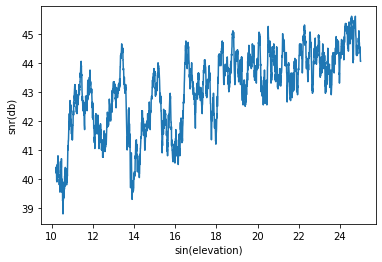

In [13]:
plt.plot(elevation_filtered,snr1_volt_filtered)
plt.xlabel('sin(elevation)')
plt.ylabel('snr(db)')

In [14]:
para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),design_matrix.T),snr1_volt_filtered)
print(para)

[[-4.63407859e-04]
 [ 2.41990475e-01]
 [ 3.89319160e+01]]


(2501, 1)


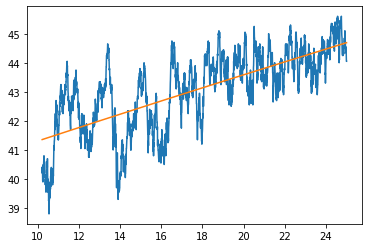

In [15]:
print(snr1_volt_filtered.shape)
snr1_ref = snr1_volt_filtered - (elevation_filtered**2 * para[0,0] + para[1,0]*elevation_filtered + para[2,0])
plt.plot(elevation_filtered,snr1_volt_filtered)
plt.plot(elevation_filtered,(elevation_filtered**2 * para[0,0] + para[1,0]*elevation_filtered + para[2,0]))


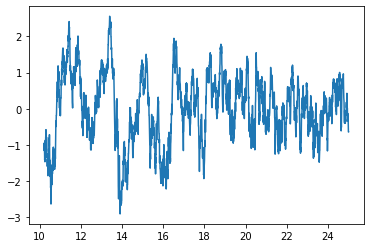

In [16]:
plt.plot(elevation_filtered,snr1_ref)

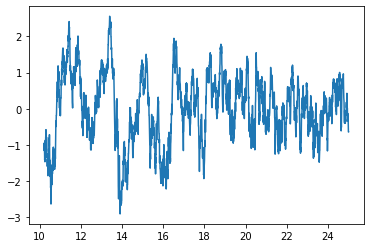

In [17]:
elevation_filtered_choosen = elevation_filtered
snr1_ref_choosen = snr1_ref
plt.plot(elevation_filtered_choosen,snr1_ref_choosen)


[3.10520052]


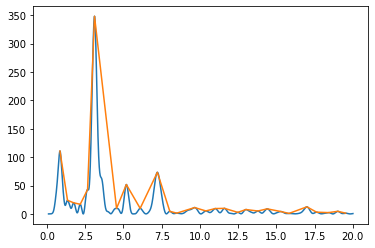

In [18]:
x_data = (np.sin(elevation_filtered_choosen*np.pi/180) * 4 * np.pi / WAVELENTH_S1).ravel()
y_data = snr1_ref_choosen.ravel()
w = np.linspace(0.1,20,10000)
power = signal.lombscargle(x_data,y_data,w,normalize=True)
power = signal.lombscargle(x_data,y_data,w)
plt.plot(w,power)


peaks,_= signal.find_peaks(power)
plt.plot(w[peaks],power[peaks])
peaks_power = power[peaks]

h = w[peaks]
h = h[peaks_power==max(peaks_power)]
print(h)

[3.104999999999768]


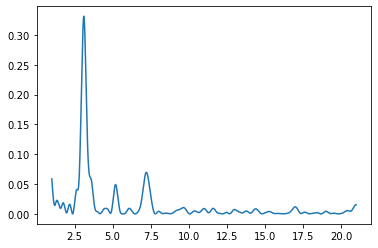

In [19]:
time_length = 0
time_list, height_list, azimut_list = esth.split_result(dataframe,time_length,min_height=1,max_height=20)
print(height_list)


In [20]:
dataframe['time'].iat[-1]-dataframe['time'].iat[0]


Timedelta('0 days 00:43:55')

In [21]:
timedelta(seconds=len(dataframe['time'])-1)

datetime.timedelta(seconds=2635)

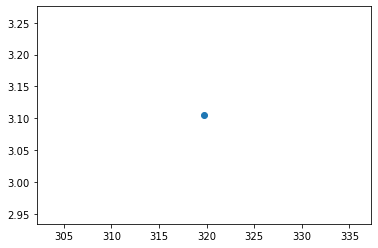

In [22]:
plt.scatter(azimut_list,height_list)